In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc, asc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

**Design a query to retrieve the last 12 months of precipitation data and plot the results**

In [10]:
# Calculate the date 1 year ago from the last data point in the database

enddate = session.query(Measurement.date).order_by(desc(Measurement.date)).limit(1).all()
print(enddate)

[('2017-08-23',)]


In [11]:
# Perform a query to retrieve the data and precipitation scores

lastyearsrain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-13', Measurement.date <= '2017-08-13').all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

df_rain = pd.DataFrame(lastyearsrain)\
.dropna()\
.sort_values(by= 'date', ascending= True)\
.set_index('date')

df_rain.head()

,prcp
date,
2016-08-14,0.00
2016-08-14,0.00
2016-08-14,0.75
2016-08-14,0.17
2016-08-14,0.10


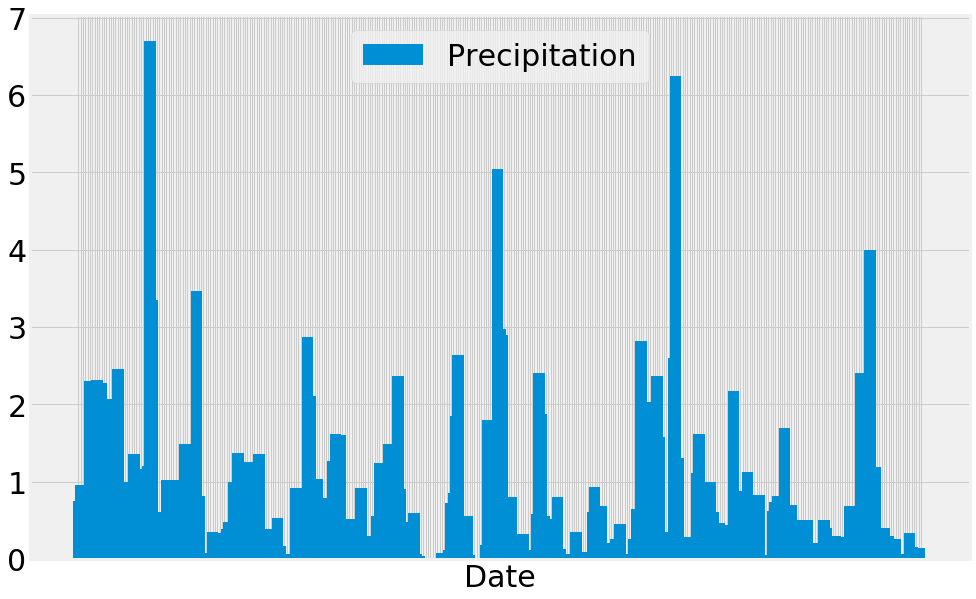

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(15,10))
plt.bar(df_rain.index, df_rain['prcp'], width=5, label='Precipitation')
plt.xlabel("Date", fontsize=30)
plt.tick_params(labelsize=30, labelbottom=False)
plt.legend(loc='upper center', fontsize=30)
plt.show()
plt.savefig('prcp_bar.png')

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df_rain.describe()

,prcp
count,2038.000000
mean,0.181237
std,0.466027
min,0.000000
25%,0.000000
50%,0.020000
75%,0.137500
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Station.station).all()

for stations in enumerate(station_count, 1):
    print(stations)

(1, ('USC00519397',))
(2, ('USC00513117',))
(3, ('USC00514830',))
(4, ('USC00517948',))
(5, ('USC00518838',))
(6, ('USC00519523',))
(7, ('USC00519281',))
(8, ('USC00511918',))
(9, ('USC00516128',))


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

for i in active_station:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

active_hitemp = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(desc(Measurement.tobs)).limit(1).all()
active_lotemp = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(asc(Measurement.tobs)).limit(1).all()
active_avgtemp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

for hi in active_hitemp:
    print(f"Hightemp = {active_hitemp}")

for lo in active_hitemp:
    print(f"Lowtemp = {active_lotemp}")
    
print(f'Avgtemp = {active_avgtemp}')

Hightemp = [('USC00519281', 85.0)]
Lowtemp = [('USC00519281', 54.0)]
Avgtemp = [('USC00519281', 71.66378066378067)]


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).all()

for tobs in most_tobs:
    print(tobs)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


![precipitation](Images/station-histogram.png)

In [19]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_enddate = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(desc(Measurement.date)).limit(1).all()
print(tobs_enddate)

[('2017-08-18',)]


In [55]:
tobs_datapull = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281', Measurement.date <= "2017-08-18", Measurement.date >= "2016-08-18").all()

tobz=[]
for stuff in tobs_datapull:
    tobz.append(*stuff)

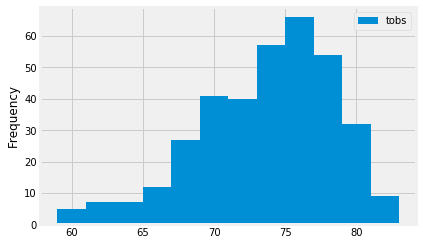

In [66]:
plt.hist(tobz, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()
plt.savefig('tobs_histogram.png')

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
